In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


import warnings 

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("rfm marketing framework.csv")
df.head()

,Recency,Frequency,Monetary,recency_score,frequeny_score,monetary_score,RFM_SCORE,Segments
0,171,11,206.36,2,5,4,25,Can't Loose
1,9,2,162.95,5,2,3,52,Potential Loyalist
2,80,1,14.39,2,1,1,21,Hibernating
3,49,2,373.44,3,2,5,32,About to Sleep
4,17,1,49.46,5,1,2,51,New Customer


In [4]:
X = df[["Recency", "Frequency", "Monetary"]]

- Since the RFM includes some Outliers I will Use the Trimmed Variance as it is robust to outliers.

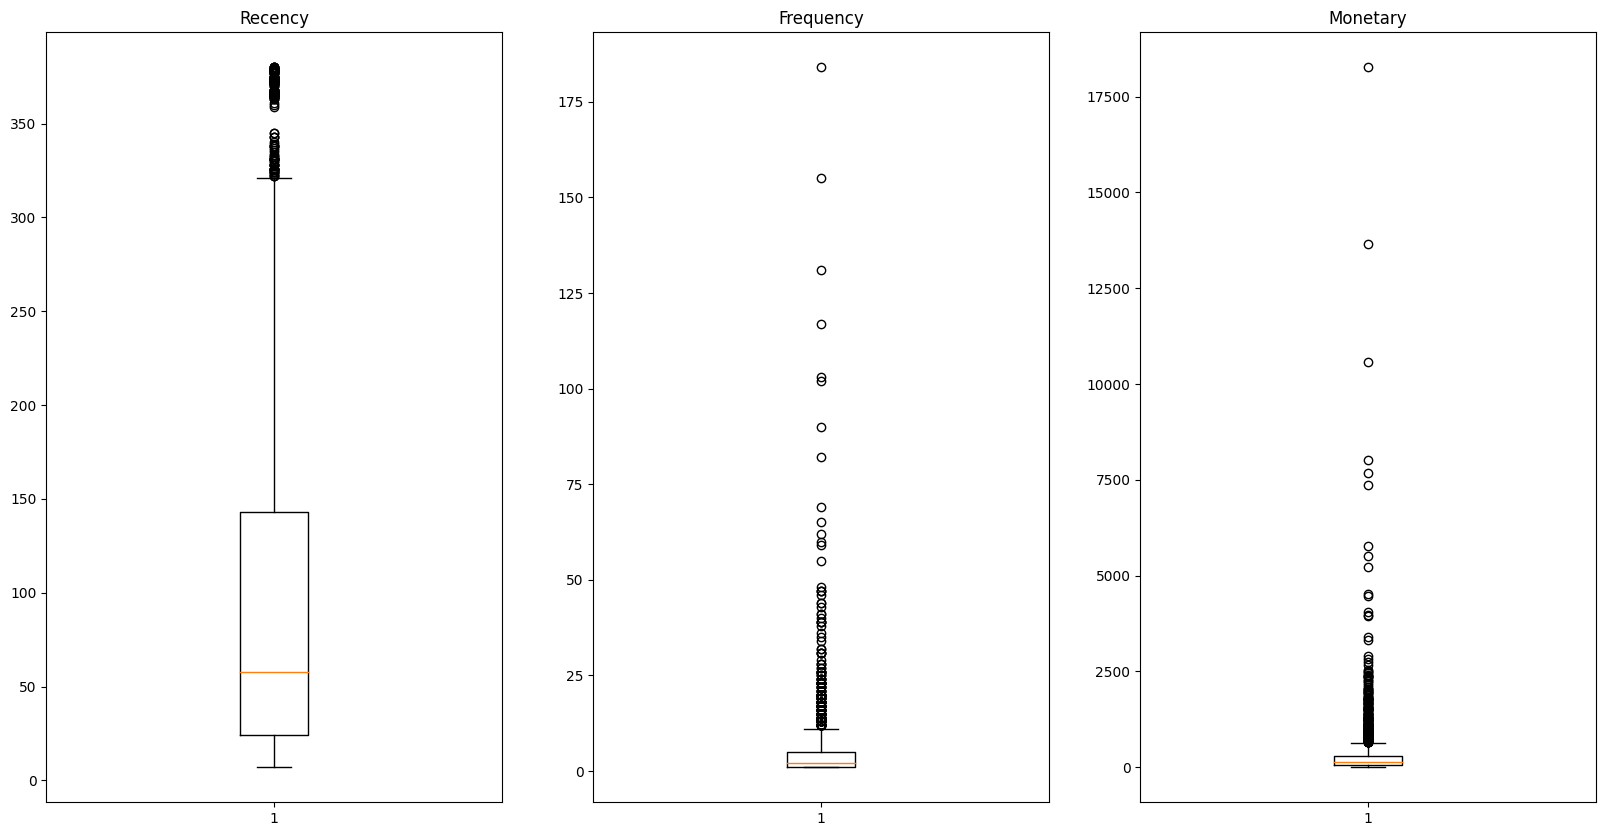

In [5]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

# Flatten the axs array to easily access each subplot
axs = axs.flatten()

# Create a boxplot for each column in the DataFrame
for i, column in enumerate(X.columns):
    axs[i].boxplot(df[column])
    axs[i].set_title(column)
    

plt.savefig('figs/box-plot for the rfm.png', format='png')
plt.show()

In [6]:
# Calculate trimmed variance
trim_var = X.apply(trimmed_var).sort_values().tail(10)
trim_var

Frequency        4.170659
Recency       4297.563225
Monetary     19570.232920
dtype: float64

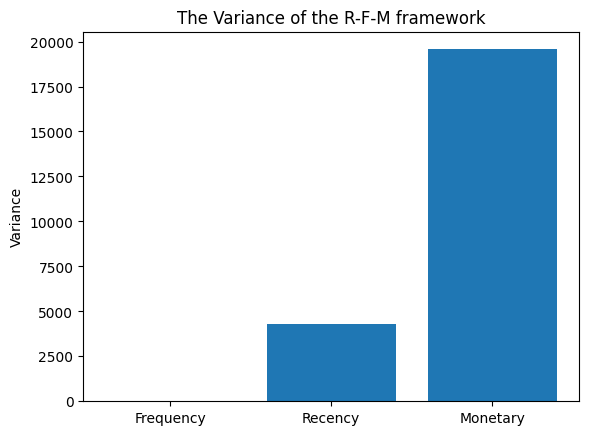

In [7]:
plt.bar(trim_var.index, trim_var)

plt.xlabel("")
plt.ylabel("Variance")
plt.title("The Variance of the R-F-M framework")

plt.savefig("figs/trimmed var for RFM.png", format="png")
plt.show()

In [8]:
n_clusters = range(2, 16)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for i in n_clusters:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=i, random_state=42))
    model.fit(X)
    
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
    silhouette_scores.append(silhouette_score(X, model.named_steps['kmeans'].labels_))
print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [8596.384090098707, 5045.807468967796, 3303.287149853404, 2664.7843022042457, 2254.118438558762, 1867.8942112904274, 1607.4365954964005, 1435.9671723387135, 1278.2417825589769, 1171.674985456742, 1056.2019065213462]

Silhouette Scores: [0.9581274552600325, 0.15368907732243495, 0.30698422956721616]


- ***I choose the best number of clusters based on lower inertia score and higher silhouette score.***
    - - Seems that 3 is the best number of clusters.

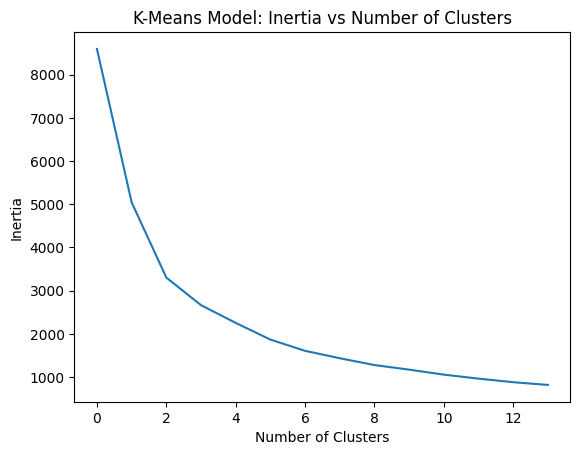

In [9]:
plt.plot(inertia_errors)

plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("K-Means Model: Inertia vs Number of Clusters")
plt.savefig("figs/Inertia errors scores over number of clusters.png", format="png")

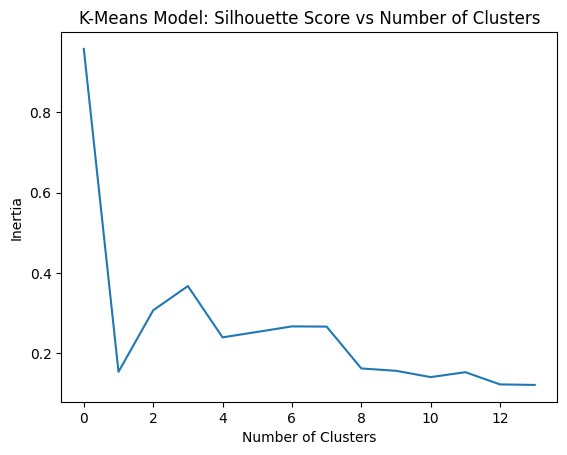

In [10]:
plt.plot(silhouette_scores)

plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("K-Means Model: Silhouette Score vs Number of Clusters")
plt.savefig("figs/silhouette scores over number of clusters.png", format="png")

# ***Model Creation***
- The Model Created Three segments based on the RFM values.
    - - `Segment 0` (High Recency, Low Frequency, Low Monetary) those are the customers who are pooely interacting with the store.
    - - `Segment 1` (Medium Recency, Medium Frequency, Medium Monetary) those are the cutomers who need more attention from the marketing team.
    - - `Segment 2` (High Recency, High Frequency, High Monetary) Those are the VIP or Champions the best customer.

In [11]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [12]:
labels = final_model.named_steps['kmeans'].labels_
segments = []
for i, label in enumerate(labels):
    if label == 0:
        segments.append("Low Value Customer")
    elif label == 1:
        segments.append("Medium Value Customer")
    else:
        segments.append("High Value Customer")

In [22]:
X["Segments"] = segments
X.to_csv("Clustering.csv", index=False)
X.head()

,Recency,Frequency,Monetary,Segments
0,171,11,206.36,Low Value Customer
1,9,2,162.95,Medium Value Customer
2,80,1,14.39,Medium Value Customer
3,49,2,373.44,Medium Value Customer
4,17,1,49.46,Medium Value Customer


In [13]:
xgb = X.groupby(segments).mean()
xgb

,Recency,Frequency,Monetary
High Value Customer,8.888889,114.777778,8978.654444
Low Value Customer,243.970009,1.682287,91.188757
Medium Value Customer,47.280383,4.878469,298.999113


In [14]:
X.groupby(segments).describe().T

High Value Customer  Low Value Customer  \
Recency   count             9.000000         1067.000000   
          mean              8.888889          243.970009   
          std               2.803767           67.792857   
          min               7.000000          134.000000   
          25%               7.000000          188.000000   
          50%               7.000000          234.000000   
          75%              10.000000          293.500000   
          max              14.000000          380.000000   
Frequency count             9.000000         1067.000000   
          mean            114.777778            1.682287   
          std              36.680300            1.324221   
          min              69.000000            1.000000   
          25%              90.000000            1.000000   
          50%             103.000000            1.000000   
          75%             131.000000            2.000000   
          max             184.000000           19.000000   
Monetary  count             9.000000         1067.000000   
          mean           8978.654444           91.188757   
          std            4519.337656          109.902746   
          min            3953.080000            0.290000   
          25%            5771.370000           27.805000   
          50%            7682.430000           60.000000   
          75%           10570.850000          111.975000   
          max           18264.790000         1220.680000   

                 Medium Value Customer  
Recency   count            3135.000000  
          mean               47.280383  
          std                33.483980  
          min                 7.000000  
          25%                21.000000  
          50%                37.000000  
          75%                69.000000  
          max               154.000000  
Frequency count            3135.000000  
          mean                4.878469  
          std                 5.757731  
          min                 1.000000  
          25%                 2.000000  
          50%                 3.000000  
          75%                 6.000000  
          max                65.000000  
Monetary  count            3135.000000  
          mean              298.999113  
          std               402.699247  
          min                 0.850000  
          25%                71.525000  
          50%               167.570000  
          75%               369.605000  
          max              5234.950000

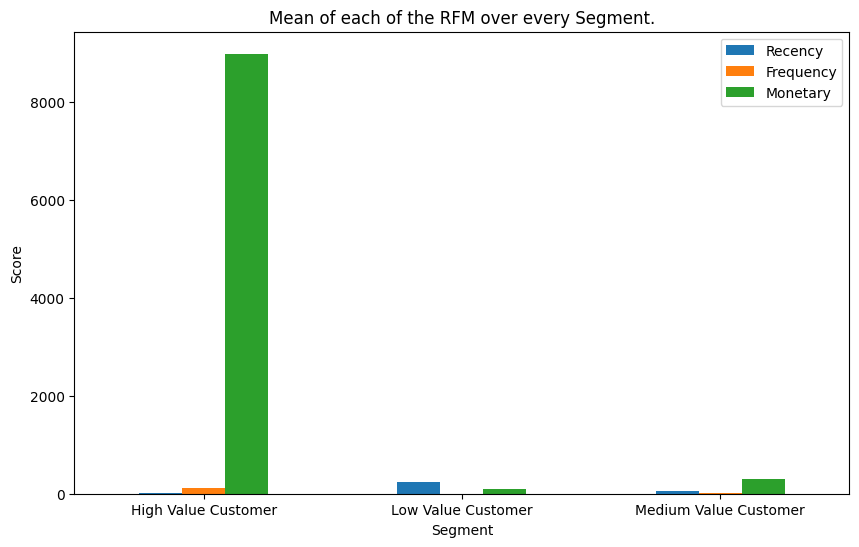

In [23]:
xgb.plot(kind="bar", figsize=(10, 6))

plt.xlabel("Segment")
plt.ylabel("Score")
plt.title("Mean of each of the RFM over every Segment.")
plt.xticks(rotation=0)

plt.savefig("figs/RFM means on each segment.png", format="png")
plt.show()

- ***Now I will transform the data into 2D so I can Plot it to see how the model Segmented the Customers.***

In [16]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4211, 2)


,PC1,PC2
0,-61.187649,71.675326
1,-98.594485,-91.783513
2,-249.711284,-26.401684
3,110.237868,-43.916372
4,-212.308662,-88.040699


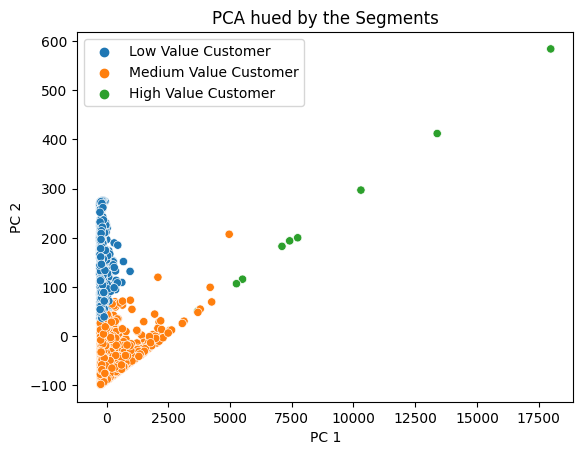

In [17]:
sns.scatterplot(x=X_pca['PC1'], y=X_pca['PC2'], hue=segments)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA hued by the Segments")

plt.savefig("figs/2D PCA with segmentation.png", format="png")

In [18]:
import plotly.express as px

# Generate example data
x = X["Recency"]
y = X["Frequency"]
z = X["Monetary"]

# Create a 3D scatter plot
fig = px.scatter_3d(x=x, y=y, z=z, color=segments)

# Set labels and title
fig.update_layout(scene=dict(xaxis_title='Recency',
                             yaxis_title='Frequency',
                             zaxis_title='Monetary'),
                  title='3D Scatter Recency Frequency Monetary')

# Show the plot
fig.show()